In [190]:
import numpy as np
import random
import keras
import keras.backend as K
from keras import Model
from keras.layers import Dense, Input, Flatten, Conv1D, Reshape
from keras import optimizers
from keras import losses

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]='5,6,7'

In [2]:
#PARAMS
%matplotlib notebook
#WINDOW_SIZE = 100
CLIP_LEN=1000
NUM_BLIPS = 2000
BLIP_LEN = 200
MAX_FREQ=BLIP_LEN//20

In [3]:
#MODEL
inp = Input(shape=(CLIP_LEN,))
inpr = Reshape(target_shape=(CLIP_LEN,1,))(inp)
h1 = Conv1D(CLIP_LEN//2,100,activation='relu')(inpr)
h2 = Conv1D(CLIP_LEN//4,200,activation='relu')(h1)
h3 = Conv1D(CLIP_LEN//8,100,activation='relu')(h2)
h4 = Conv1D(CLIP_LEN//16,200,activation='relu')(h3)
#h1 = Dense(CLIP_LEN//2,activation='relu')(inp)
h4flat = Flatten()(h4)
h5 = Dense(CLIP_LEN//32,activation='relu')(h4flat)
#h3 = Flatten()(h2)
out = Dense(4,activation='relu')(h5)

model = Model(inputs=inp,outputs=out)



In [179]:
def absolute_to_relative_params(params):
    rel_params = np.zeros_like(params).astype(float)
    for i in range(len(params)):
        if i%2 == 0:
            rel_params[i]=float(params[i])/float(CLIP_LEN-BLIP_LEN)
        else:
            rel_params[i]=float(params[i]-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)
    return rel_params

def relative_to_absolute_params(params):
    abs_params = np.zeros_like(params).astype(int)
    for i in range(len(params)):
        if i%2 == 0:
            abs_params[i]=int(float(params[i])*float(CLIP_LEN-BLIP_LEN))
        else:
            abs_params[i]=int(float(params[i])*float(BLIP_LEN-MAX_FREQ)+MAX_FREQ)
    return abs_params

<IPython.core.display.Javascript object>


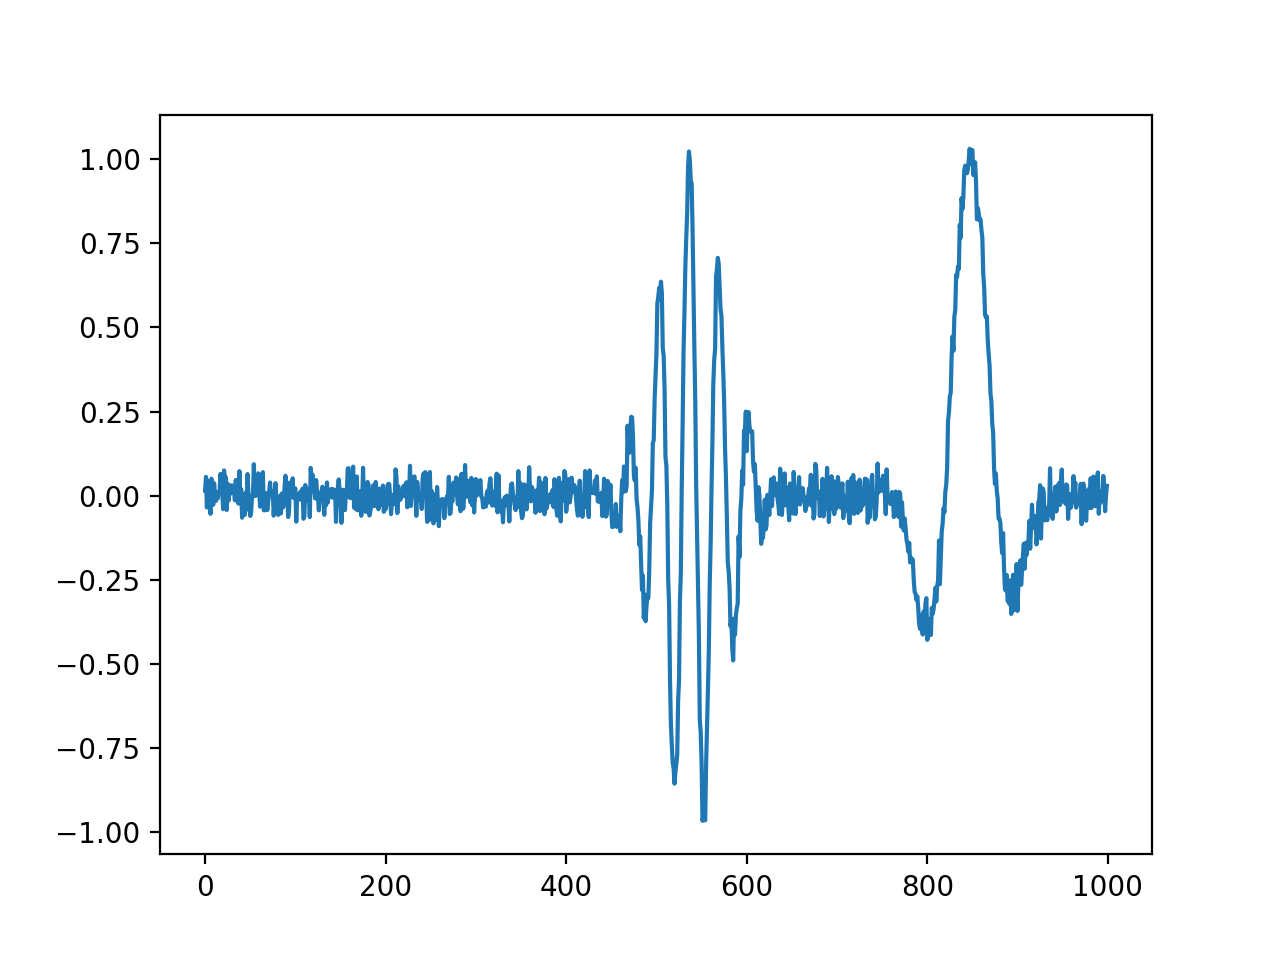

In [235]:
%matplotlib notebook
#DATAGEN
def generate_blip(start,length,half_wavlen,clip_size):
    clip = np.zeros(clip_size)
    osc = -1.
    gaus=np.exp(-((np.arange(length)-length//2)/(length/4))**2)
    #gaus=np.ones(length)
    for i in range(start,start+length):
        if (i-start)%(half_wavlen) == 0:
            osc *= -1.
        clip[i] = gaus[i-start]*np.sin(float(2*i*np.pi)/half_wavlen)
    return clip

def generate_multi_blip(num_blips):
    blip_sum = np.zeros(CLIP_LEN)
    for j in range(num_blips):
        s = np.random.randint(0,CLIP_LEN-BLIP_LEN)
        w = np.random.randint(MAX_FREQ,BLIP_LEN)
        #print(s,w)
        blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
        #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
        blip_sum+=blip_clip
        #y.append([float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
        #params[2*j] = float(s)/float(CLIP_LEN-BLIP_LEN)
        #params[2*j+1] = float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)
    return blip_sum
        

def generate_multi_blip_ordered(num_blips):
    blip_sum = np.zeros(CLIP_LEN)
    s=0
    for j in range(num_blips):
        s = np.random.randint(s,CLIP_LEN-BLIP_LEN)
        w = np.random.randint(MAX_FREQ,BLIP_LEN)
        #print(s,w)
        blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
        #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
        blip_sum+=blip_clip
        #y.append([float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
        #params[2*j] = s#float(s)/float(CLIP_LEN-BLIP_LEN)
        #params[2*j+1] = w#float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)
    return blip_sum

def generate_specific_multi_blip(params,num_blips):
    abs_params = relative_to_absolute_params(params)
    clip=np.zeros(CLIP_LEN)
    for j in range(num_blips):
        clip+=generate_blip(int(abs_params[2*j]),BLIP_LEN,int(abs_params[2*j+1]),CLIP_LEN)
    return clip

def generate_noise(clip_size,lvl=0.05):
    return (2*np.random.random(clip_size)-1)*lvl

def get_window(blip_clips,params,batch_size=32):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            ind = np.random.choice(range(len(blip_clips)))
            blip_clip = blip_clips[ind]
            s = np.random.randint(0,CLIP_LEN-WINDOW_SIZE)
            f = s + WINDOW_SIZE
            x.append(blip_clip[s:f])
            y.append((params[ind,0],params[ind,2]))
        yield (np.array(x), np.array(y))


def randomized_blip_generator(batch_size=32):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            s = np.random.randint(0,CLIP_LEN-BLIP_LEN)
            w = np.random.randint(MAX_FREQ,BLIP_LEN)
            #print(s,w)
            blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
            #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
            x.append(blip_clip)
            #y.append([float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
            y.append([float(s)/float(CLIP_LEN-BLIP_LEN),float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
        yield (np.array(x), np.array(y))

def randomized_multi_blip_generator(batch_size=32,num_blips=1):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            blip_sum = np.zeros(CLIP_LEN)
            params = np.zeros(num_blips*2)
            for j in range(num_blips):
                s = np.random.randint(0,CLIP_LEN-BLIP_LEN)
                w = np.random.randint(MAX_FREQ,BLIP_LEN)
                #print(s,w)
                blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
                #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
                blip_sum+=blip_clip
                #y.append([float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
                params[2*j] = s#float(s)/float(CLIP_LEN-BLIP_LEN)
                params[2*j+1] = w#float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)
            x.append(blip_sum)
            y.append(absolute_to_relative_params(params))
        yield (np.array(x), np.array(y))

def randomized_multi_blip_generator_ordered(batch_size=32,num_blips=1):
    while True:
        x=[]
        y=[]
        for i in range(batch_size):
            blip_sum = np.zeros(CLIP_LEN)
            params = np.zeros(num_blips*2)
            s=0
            for j in range(num_blips):
                s = np.random.randint(s,CLIP_LEN-BLIP_LEN)
                w = np.random.randint(MAX_FREQ,BLIP_LEN)
                #print(s,w)
                blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+generate_noise(CLIP_LEN)
                #blip_clip = vec_gen_blip(np.array([s,w]))+generate_noise(CLIP_LEN)
                blip_sum+=blip_clip
                #y.append([float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)])
                params[2*j] = s#float(s)/float(CLIP_LEN-BLIP_LEN)
                params[2*j+1] = w#float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)
            x.append(blip_sum)
            y.append(absolute_to_relative_params(params))
        yield (np.array(x), np.array(y))

    


for x,y in randomized_multi_blip_generator(batch_size=1,num_blips=2):
    plt.plot(np.arange(x[0].shape[0]),x[0])
    plt.show()
    #plt.xlim(y[0,0],y[0,0]+BLIP_LEN)
    break

In [ ]:
def vec_gen_blip(vec, length=BLIP_LEN,clip_size=CLIP_LEN,batch_size=32):
    clip=K.zeros(clip_size)
    xarg=K.arange(length,dtype='float')
    gaus = K.exp(-4*((np.arange(length,dtype='float32')-length//2)/length))

    blip_freq = 2*np.pi*xarg/vec[...,1]
    blip_sub = K.sin(blip_freq)
    #blip = K.expand_dims(gaus,0)*blip_sub
    #print(K.dtype(gaus),K.dtype(blip_sub))
    blip = gaus*blip_sub
    print(blip.get_shape())
    K.print_tensor(K.shape(blip))
    clip_slice = tf.slice(clip, [K.cast(vec[...,0],dtype='int32')], [K.cast(vec[...,0]+length,dtype='int32')])
    clip_slice.assign(blip)
    return clip

def analysis_loss(y_true, y_pred):
    diff = vec_gen_blip(y_pred)
    diff -= vec_gen_blip(y_true)
    return np.linalg.norm(diff,axis=-1)


In [39]:

def loss(y,yhat):
    return K.sum((y-yhat)**2)

def loss_non_graph(y,yhat):
    return sum((y-yhat)**2)

In [40]:
model.summary()

model.compile(optimizers.adam(lr=10e-8),loss=loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 901, 500)          50500     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 702, 250)          25000250  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 603, 125)          3125125   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 404, 62)           1550062   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25048)             0         
__________

In [296]:
model.fit_generator(randomized_multi_blip_generator_ordered(batch_size=32,num_blips=2),steps_per_epoch=1000, epochs=1000)

Epoch 1/1000
 378/1000 [==========>...................] - ETA: 5:51 - loss: 0.4257

KeyboardInterrupt: 

[[0.86067297 0.55904609 0.90665669 0.56795315]
 [0.85458112 0.67294735 0.89556903 0.56657821]
 [0.00609185 0.11390125 0.01108766 0.00137494]]
LOSS:  0.013135432956863188


<IPython.core.display.Javascript object>


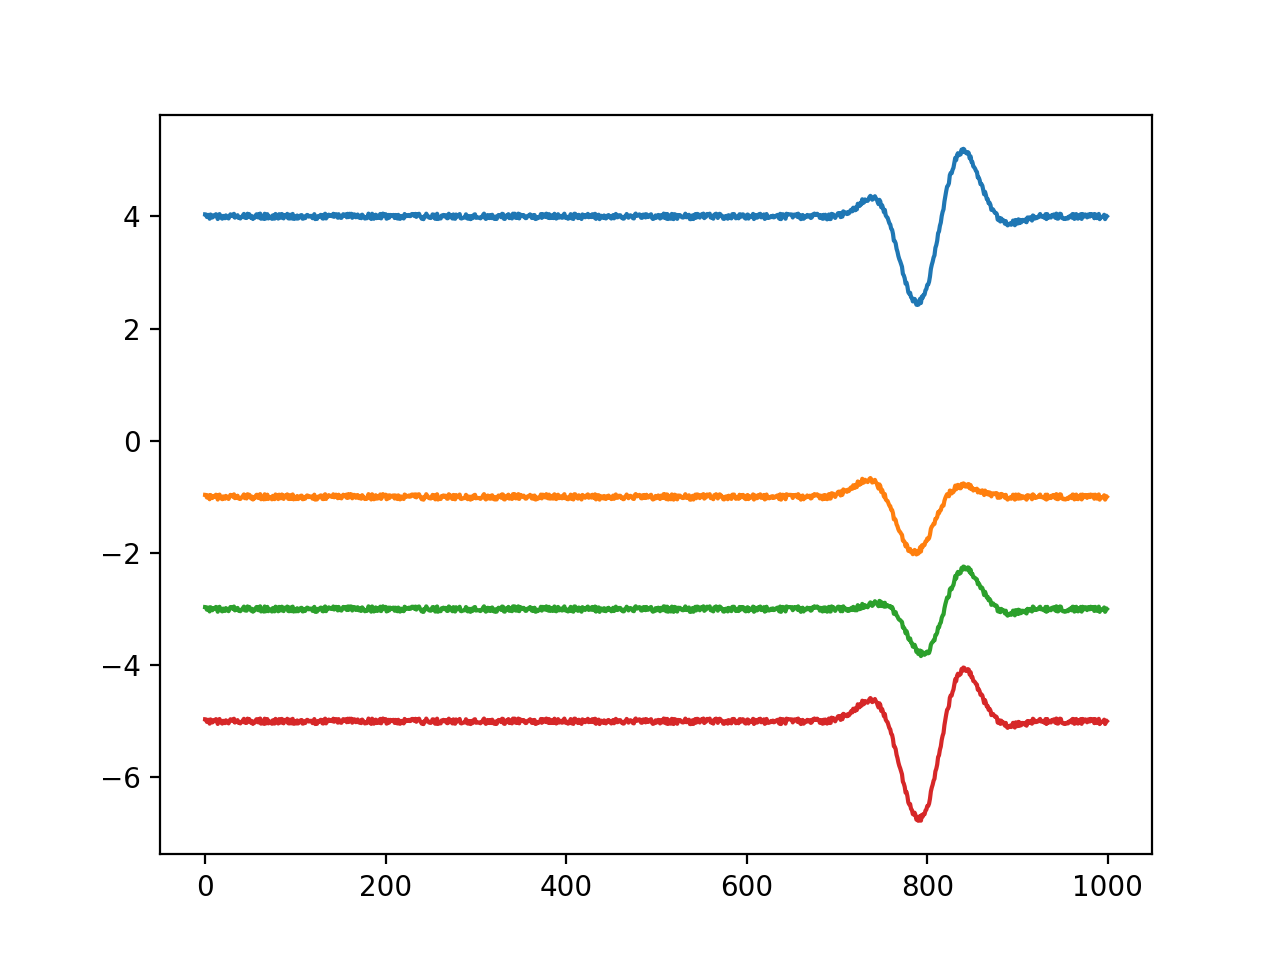

In [308]:
%matplotlib notebook


other=random.random()
params=[other,random.random(),(random.random())*(1.-other)+other,random.random()]
#params=[0.2,.5,0.6,0.2]
noise=generate_noise(CLIP_LEN)

blip_clip = generate_specific_multi_blip(params,2)+noise

output = model.predict([[blip_clip]])
prediction=output[0]
print(np.stack([params,prediction,np.abs(params-prediction)]))
#print(prediction)

blip_clip_recon = generate_specific_multi_blip(prediction[0:2],1)+noise
blip_clip_recon2 = generate_specific_multi_blip(prediction[2:4],1)+noise
blip_clip_recon3 = generate_specific_multi_blip(prediction,2)+noise





print("LOSS: ", loss_non_graph(params,prediction))

plt.plot(blip_clip+4)
plt.plot(blip_clip_recon-1)
plt.plot(blip_clip_recon2-3)
plt.plot(blip_clip_recon3-5)

abs_params = relative_to_absolute_params(params)
abs_prediction = relative_to_absolute_params(prediction)
# plt.axvline(abs_params[0],c='r')
# plt.axvline(abs_params[2],c='r')
# plt.axvline(abs_prediction[0])
# plt.axvline(abs_prediction[2])
plt.show()

<IPython.core.display.Javascript object>


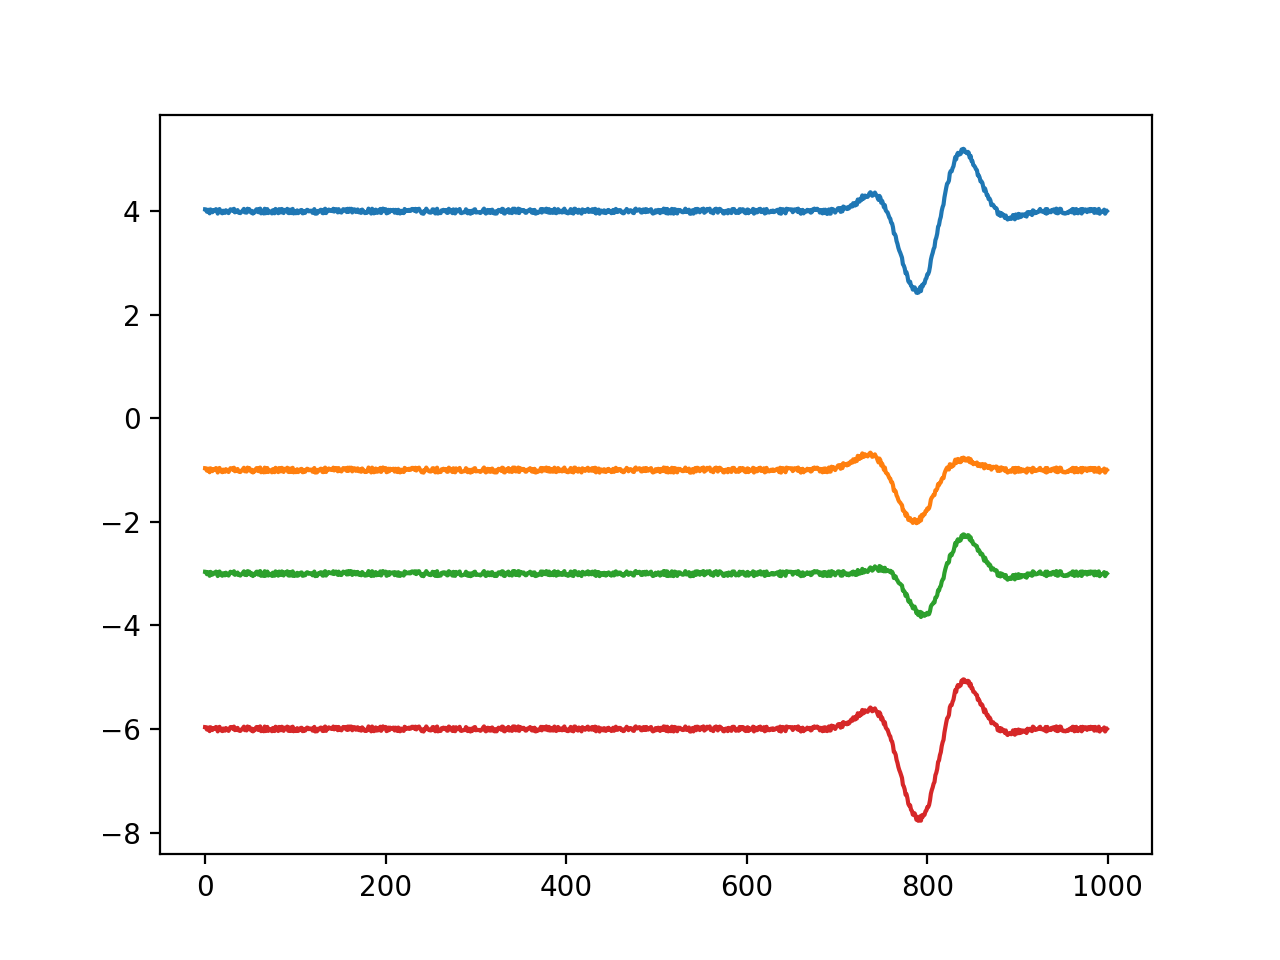

In [309]:
%matplotlib notebook
plt.plot(blip_clip+4)
plt.plot(blip_clip_recon-1)
plt.plot(blip_clip_recon2-3)
plt.plot(blip_clip_recon3-6)
plt.show()

[[227.           0.227      136.           0.66315789]
 [219.72141266   0.27465177 127.32542038   0.61750221]]
LOSS:  0.004355132104366959


<IPython.core.display.Javascript object>


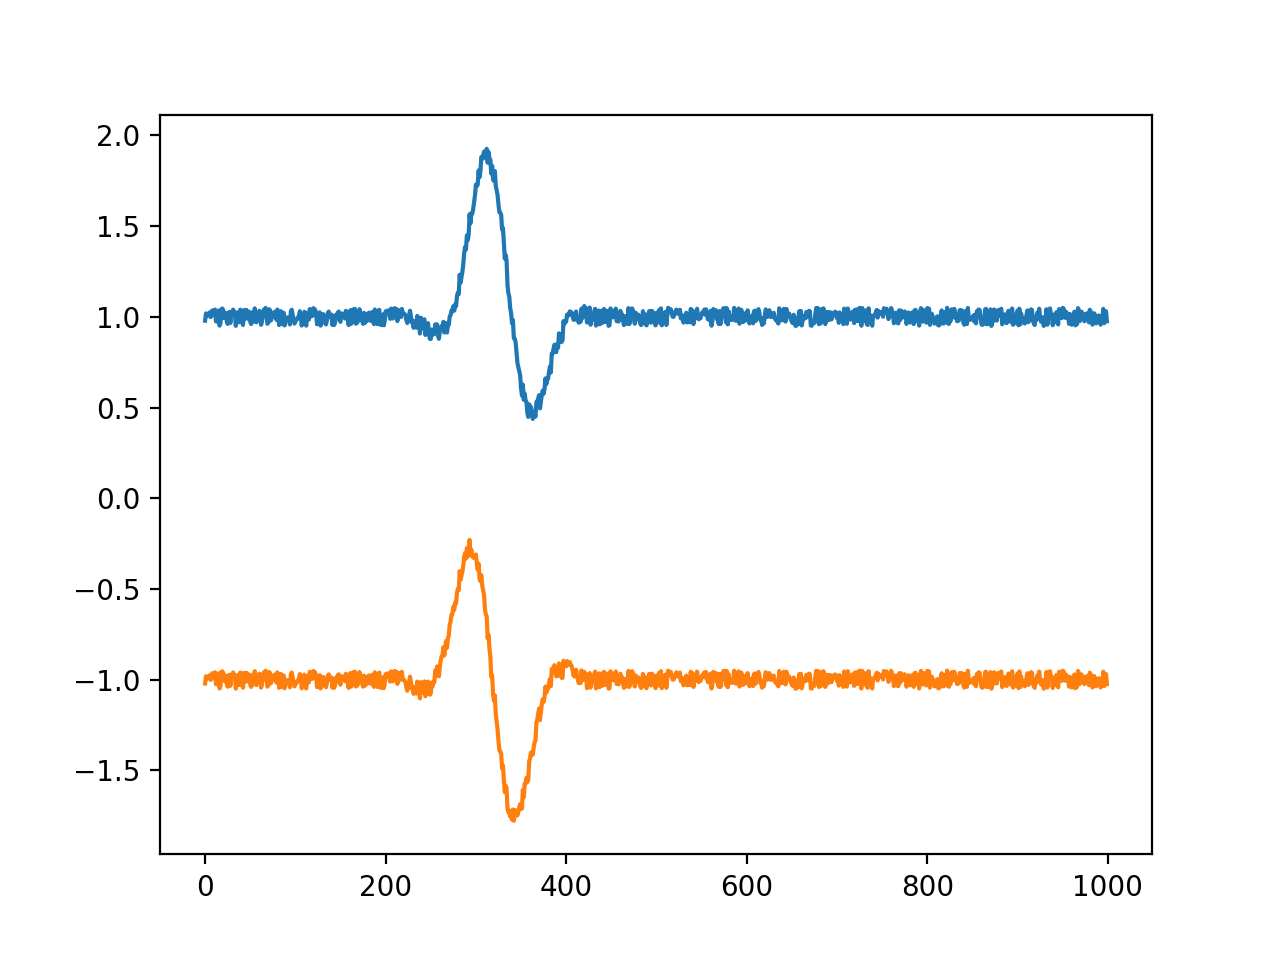

In [188]:
%matplotlib notebook

s = np.random.randint(0,CLIP_LEN-BLIP_LEN)
w = np.random.randint(MAX_FREQ,BLIP_LEN)

ssc = float(s)/float(CLIP_LEN)
wsc = float(w-MAX_FREQ)/float(BLIP_LEN-MAX_FREQ)

noise=generate_noise(CLIP_LEN)
blip_clip = generate_blip(s,BLIP_LEN,w,CLIP_LEN)+noise

prediction = model.predict([[blip_clip]])
#print(prediction)
s_hat=prediction[0,0]
w_hat=prediction[0,1]
print(np.array([[s,ssc,w,wsc],
[(CLIP_LEN-BLIP_LEN)*s_hat,s_hat,w_hat*(BLIP_LEN-MAX_FREQ)+MAX_FREQ,w_hat]]))
#blip_clip_recon = generate_blip(0,BLIP_LEN,w_hat*(BLIP_LEN-MAX_FREQ)+MAX_FREQ,CLIP_LEN)+noise
blip_clip_recon = generate_blip(int(s_hat*(CLIP_LEN-BLIP_LEN)),BLIP_LEN,w_hat*(BLIP_LEN-MAX_FREQ)+MAX_FREQ,CLIP_LEN)+noise

print("LOSS: ", loss_non_graph(np.array([ssc,wsc]),np.array([s_hat,w_hat])))

plt.plot(blip_clip+1)
plt.plot(blip_clip_recon-1)
plt.show()